In [ ]:
# libraries
import pandas as pd
import numpy as np
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
tqdm.pandas()

# nlp
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec, KeyedVectors, FastText
from gensim.models.phrases import Phrases
from gensim.scripts.glove2word2vec import glove2word2vec

# dl libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Load Dataset

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c word2vec-nlp-tutorial

 97% 50.0M/51.7M [00:02<00:00, 39.0MB/s]
100% 51.7M/51.7M [00:02<00:00, 25.6MB/s]


In [ ]:
! kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 97% 25.0M/25.7M [00:01<00:00, 32.4MB/s]
100% 25.7M/25.7M [00:01<00:00, 21.9MB/s]


In [ ]:
! unzip word2vec-nlp-tutorial.zip
! unzip testData.tsv.zip
! unzip labeledTrainData.tsv.zip
! unzip unlabeledTrainData.tsv.zip
! unzip /content/imdb-dataset-of-50k-movie-reviews.zip

Archive:  word2vec-nlp-tutorial.zip
  inflating: labeledTrainData.tsv.zip  
  inflating: sampleSubmission.csv    
  inflating: testData.tsv.zip        
  inflating: unlabeledTrainData.tsv.zip  
Archive:  testData.tsv.zip
  inflating: testData.tsv            
Archive:  labeledTrainData.tsv.zip
  inflating: labeledTrainData.tsv    
Archive:  unlabeledTrainData.tsv.zip
  inflating: unlabeledTrainData.tsv  
Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [ ]:
imdb = pd.read_csv('IMDB Dataset.csv')
labeled_data = pd.read_csv('labeledTrainData.tsv',sep='\t')
unlabeled_data = pd.read_csv('unlabeledTrainData.tsv', on_bad_lines='skip', sep='\t')
test_data = pd.read_csv('testData.tsv', sep='\t')

In [ ]:
imdb.head(1)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive


In [ ]:
labeled_data.head(1)

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...


In [ ]:
unlabeled_data.head(1)

,id,review
0,9999_0,"Watching Time Chasers, it obvious that it was ..."


In [ ]:
test_data.head(1)

,id,review
0,12311_10,Naturally in a film who's main themes are of m...


In [ ]:
set(imdb['sentiment'])

{'negative', 'positive'}

In [ ]:
train_data = pd.concat([labeled_data.review, unlabeled_data.review], axis=0, ignore_index=True)
train_data = pd.DataFrame(train_data)

In [ ]:
imdb['sentiment'] = [1 if i=='positive' else 0 for i in imdb['sentiment']]

In [ ]:
labeled_data, unlabeled_data = labeled_data.drop(['id'], axis=1), unlabeled_data.drop(['id'], axis=1)

In [ ]:
all_data = pd.concat([labeled_data.review, imdb.review, unlabeled_data.review, test_data.review], axis=0, ignore_index=True)

In [ ]:
train_data =  pd.concat([labeled_data, imdb], axis=0, ignore_index=True)

In [ ]:
(train_data.review == all_data[:train_data.shape[0]]).sum()

75000

In [ ]:
all_data[-test_data.shape[0]:]

124998    Naturally in a film who's main themes are of m...
124999    This movie is a disaster within a disaster fil...
125000    All in all, this is a movie for kids. We saw i...
125001    Afraid of the Dark left me with the impression...
125002    A very accurate depiction of small time mob li...
                                ...                        
149993    Sony Pictures Classics, I'm looking at you! So...
149994    I always felt that Ms. Merkerson had never got...
149995    I was so disappointed in this movie. I am very...
149996    From the opening sequence, filled with black a...
149997    This is a great horror film for people who don...
Name: review, Length: 25000, dtype: object

In [ ]:
test_data.review

0        Naturally in a film who's main themes are of m...
1        This movie is a disaster within a disaster fil...
2        All in all, this is a movie for kids. We saw i...
3        Afraid of the Dark left me with the impression...
4        A very accurate depiction of small time mob li...
                               ...                        
24995    Sony Pictures Classics, I'm looking at you! So...
24996    I always felt that Ms. Merkerson had never got...
24997    I was so disappointed in this movie. I am very...
24998    From the opening sequence, filled with black a...
24999    This is a great horror film for people who don...
Name: review, Length: 25000, dtype: object

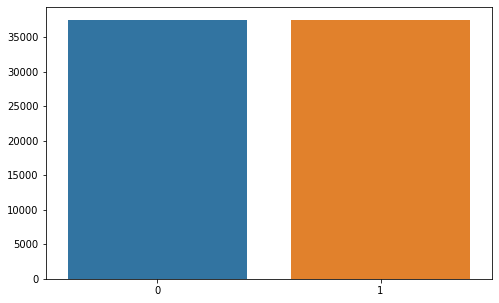

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x=train_data['sentiment'].value_counts().index, y=train_data['sentiment'].value_counts().values)
plt.show()

## Preprocessing

In [ ]:
stop_lst = stopwords.words('english')
def normalize(sentence):
  sentence = re.sub('^http', ' ', sentence)
  sentence = re.sub('[^a-z A-Z]', ' ', sentence)
  sentence = str(sentence).lower()
  return sentence

def tokenize(sentence):
  sentence = word_tokenize(sentence)
  sentence = [token for token in sentence if len(token)>2]
  return sentence

def stop_words(sentence):
  sentence = [token for token in sentence if token not in stop_lst]
  return sentence

def lemmatize(sentence):
  sentence = [WordNetLemmatizer().lemmatize(token) for token in sentence]
  return sentence

In [ ]:
train_data['review'] = train_data['review'].progress_apply(normalize)
train_data['review'] = train_data['review'].progress_apply(tokenize)
train_data['review'] = train_data['review'].progress_apply(stop_words)
train_data['review'] = train_data['review'].progress_apply(lemmatize)

100%|██████████| 75000/75000 [00:36<00:00, 2064.40it/s]


In [ ]:
all_data = all_data.progress_apply(normalize)
all_data = all_data.progress_apply(tokenize)
all_data = all_data.progress_apply(stop_words)
all_data = all_data.progress_apply(lemmatize)

100%|██████████| 149998/149998 [01:11<00:00, 2087.42it/s]


## Embedding

In [ ]:
text = []
for i in all_data:
  text.append(i)

In [ ]:
model = Word2Vec(sentences = text,
                          vector_size  = 256, sg=0,
                          min_count=2, window=5, workers=4)

In [ ]:
model.wv.most_similar('film')

[('movie', 0.8418914079666138),
 ('flick', 0.5352792739868164),
 ('cinema', 0.475547730922699),
 ('documentary', 0.46939778327941895),
 ('one', 0.46168315410614014),
 ('picture', 0.45609861612319946),
 ('certainly', 0.4406309723854065),
 ('however', 0.43780001997947693),
 ('thriller', 0.4338338077068329),
 ('therefore', 0.41475433111190796)]

In [ ]:
model.wv.most_similar(positive='king')

[('mchattie', 0.5684550404548645),
 ('frears', 0.5510572195053101),
 ('solomon', 0.5450324416160583),
 ('zalman', 0.5443341732025146),
 ('parhat', 0.5366811156272888),
 ('cannell', 0.5357308387756348),
 ('tut', 0.5354431867599487),
 ('hawking', 0.5304523706436157),
 ('furst', 0.5162526369094849),
 ('dillane', 0.5123589038848877)]

In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(model.wv.vectors)
labels = kmeans.labels_

In [ ]:
words = model.wv.index_to_key

pca = PCA(n_components=3)
vectors_3d = pca.fit_transform(model.wv.vectors)
print(pca.explained_variance_ratio_*100)

tsne = TSNE(2)
vectors_2d = tsne.fit_transform(model.wv.vectors)

[7.92101889 5.72071776 4.84542553]


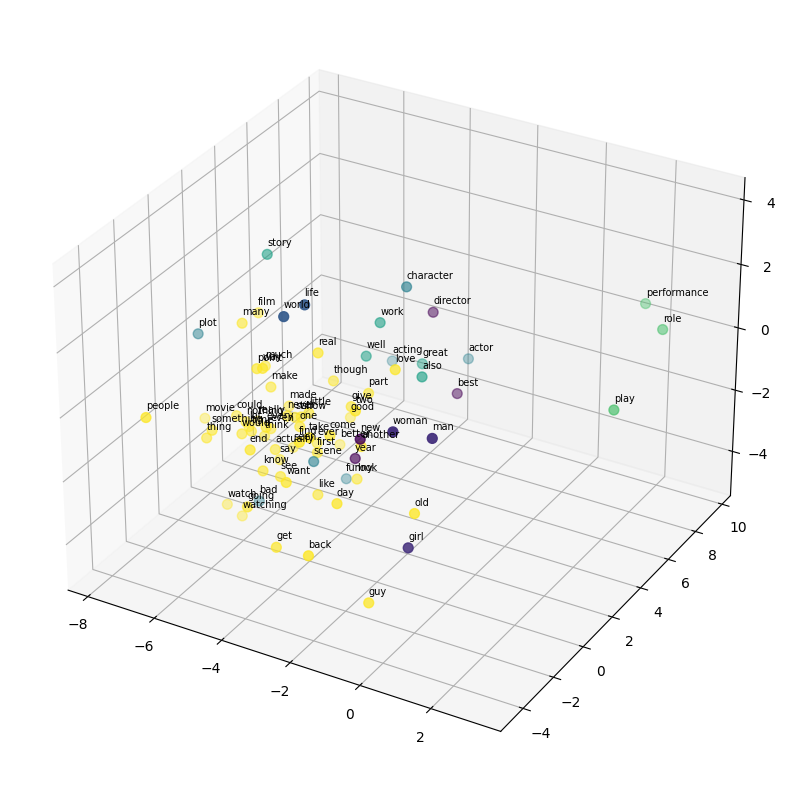

In [ ]:
fig = plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vectors_3d[0:80, 0], vectors_3d[0:80, 1], vectors_3d[0:80, 2], c=labels[0:80], s=50)

for i, word in enumerate(words[0:80]):
  ax.text(vectors_3d[i, 0], vectors_3d[i, 1], vectors_3d[i, 2]+0.25, word, fontsize=7)

plt.show()

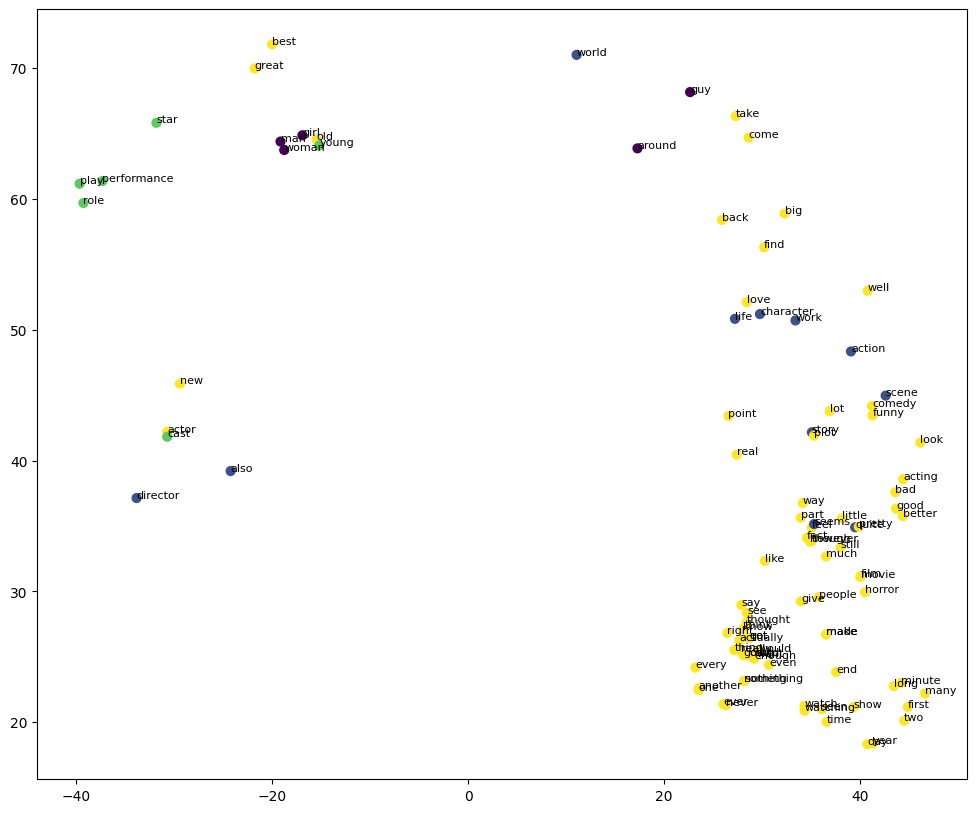

In [ ]:
fig = plt.figure(figsize=(12,10), dpi=100)
ax = fig.add_subplot(111)
ax.scatter(vectors_2d[0:100, 0], vectors_2d[0:100, 1], c=labels[0:100], s=40)

for i, word in enumerate(words[0:100]):
  ax.text(vectors_2d[i, 0], vectors_2d[i, 1], word, fontsize=8)

plt.show()

In [ ]:
model.wv.most_similar(positive=['king', 'woman'], negative=['man'])

[('princess', 0.363264799118042),
 ('parhat', 0.36116355657577515),
 ('hrothgar', 0.35864928364753723),
 ('zalman', 0.35850539803504944),
 ('siam', 0.3520009517669678),
 ('lear', 0.3437952399253845),
 ('yougoslavia', 0.33289068937301636),
 ('hong', 0.32992690801620483),
 ('queen', 0.32908833026885986),
 ('tights', 0.328949898481369)]

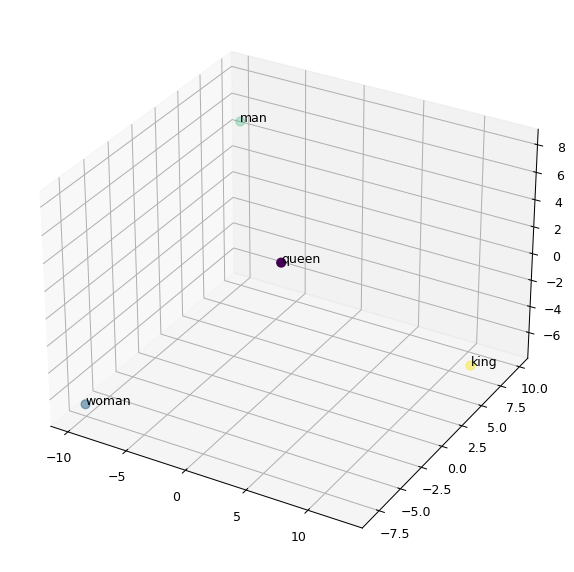

In [ ]:
words = ["man", "king", "woman", "queen"]
vectors = [model.wv[i] for i in words]
new_labels = [labels[i] for i in range(len(model.wv)) if model.wv.index_to_key[i] in words]

pca = PCA(n_components=3)
vectors_3d = pca.fit_transform(vectors)

fig = plt.figure(figsize=(10,8), dpi=90)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vectors_3d[:, 0], vectors_3d[:, 1], vectors_3d[:, 2], s=50, c=new_labels)

for i, word in enumerate(words):
  ax.text(vectors_3d[i, 0], vectors_3d[i, 1],vectors_3d[i,2], word, fontsize=10)

plt.show()

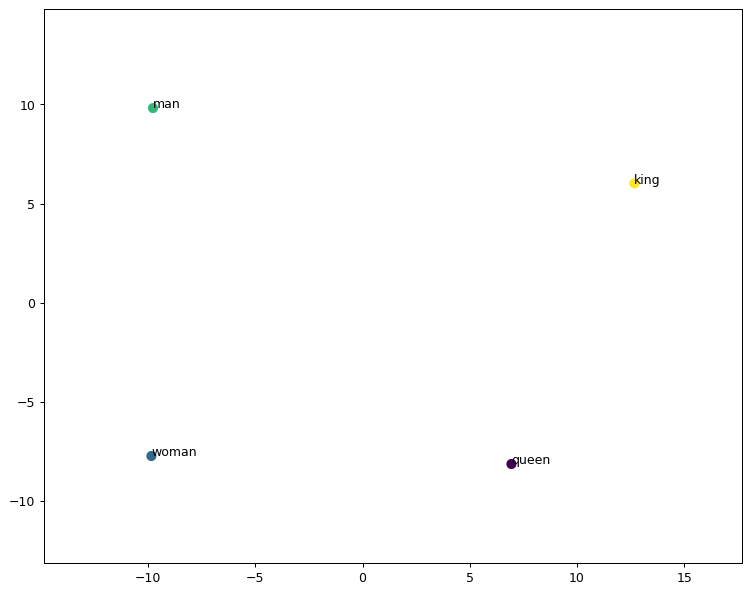

In [ ]:
words = ["man", "king", "woman", "queen"]
vectors = [model.wv[i] for i in words]
new_labels = [labels[i] for i in range(len(model.wv)) if model.wv.index_to_key[i] in words]

pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

fig = plt.figure(figsize=(10,8), dpi=90)
ax = fig.add_subplot(111)
ax.scatter(vectors_2d[:, 0], vectors_2d[:, 1], s=50, c=new_labels)

for i, word in enumerate(words):
  ax.text(vectors_2d[i, 0], vectors_2d[i, 1], word, fontsize=10)

ax.set_xlim(min(vectors_2d[:, 0]) - 5, max(vectors_2d[:, 0]) + 5)
ax.set_ylim(min(vectors_2d[:, 1]) - 5, max(vectors_2d[:, 1]) + 5)
plt.show()

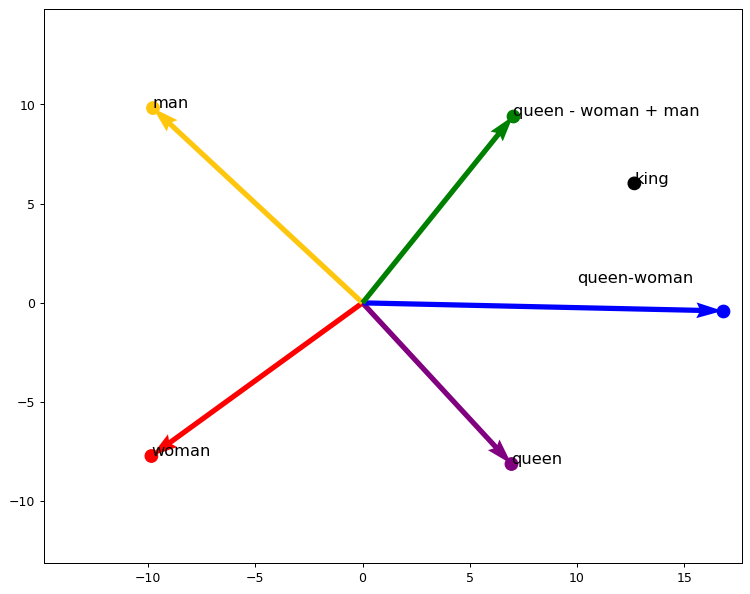

In [ ]:
words = ["man", "king", "woman", "queen"]
vectors = [model.wv[i] for i in words]
new_labels = ['#ffc60e', 'black', 'red', 'purple']

pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

fig = plt.figure(figsize=(10, 8), dpi=90)
ax = fig.add_subplot(111)
ax.scatter(vectors_2d[:, 0], vectors_2d[:, 1], s=100, c=new_labels)

for i, word in enumerate(words):
    ax.text(vectors_2d[i, 0], vectors_2d[i, 1], word, fontsize=13)

points = {word: vectors_2d[i] for i, word in enumerate(words)}
queen_point = points['queen']
woman_point = points['woman']
man_point = points['man']

queen_woman = queen_point - woman_point
plus_man = queen_woman + man_point

ax.scatter(plus_man[0], plus_man[1], s=100, c='green')
ax.text(plus_man[0], plus_man[1], 'queen - woman + man', fontsize=13)

ax.scatter(queen_woman[0], queen_woman[1], s=100, c='blue')
ax.text(queen_woman[0], queen_woman[1], 'queen-woman', fontsize=13, position=(10,1))

ax.quiver(0, 0, queen_point[0], queen_point[1], angles='xy', scale_units='xy', scale=1, color='purple',linestyle='dotted')
ax.quiver(0, 0, woman_point[0], woman_point[1], angles='xy', scale_units='xy', scale=1, color='red',linestyle='dotted')
ax.quiver(0, 0, man_point[0], man_point[1], angles='xy', scale_units='xy', scale=1, color='#ffc60e',linestyle='dotted')
ax.quiver(0, 0, queen_woman[0], queen_woman[1], angles='xy', scale_units='xy', scale=1, color='blue',linestyle='dotted')
ax.quiver(0, 0, plus_man[0], plus_man[1], angles='xy', scale_units='xy', scale=1, color='green',linestyle='dotted')

ax.set_xlim(min(vectors_2d[:, 0]) - 5, max(vectors_2d[:, 0]) + 5)
ax.set_ylim(min(vectors_2d[:, 1]) - 5, max(vectors_2d[:, 1]) + 5)
plt.show()

In [ ]:
# glove
!wget --no-check-certificate \
http://nlp.stanford.edu/data/glove.6B.zip \
-O /tmp/glove.6B.zip

import os
import zipfile

with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

f = open('/tmp/glove/glove.6B.100d.txt')

word2vec = {}

for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype="float32")
    word2vec[word] = vec
f.close()

--2024-05-15 04:55:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-05-15 04:55:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-05-15 04:55:46--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


In [ ]:
from scipy import spatial
def find_closest_embeddings(embedding):
    return sorted(word2vec.keys(), key=lambda word: spatial.distance.euclidean(word2vec[word], embedding))

In [ ]:
find_closest_embeddings(word2vec['queen']-word2vec['woman']+word2vec['man'])[:5]

['queen', 'king', 'prince', 'royal', 'majesty']

In [ ]:
glove_words = list(word2vec.keys())[300:2500]
glove_vec = list(word2vec.values())[300:2500]
glove_dict = {glove_words[i]:glove_vec[i] for i in range(len(glove_words))}

In [ ]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(glove_vec)
labels = kmeans.labels_

In [ ]:
pca = PCA(n_components=3)
vectors_3d = pca.fit_transform(glove_vec)
print(pca.explained_variance_ratio_*100)

pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(glove_vec)

[5.75155912 4.97939803 4.65720786]


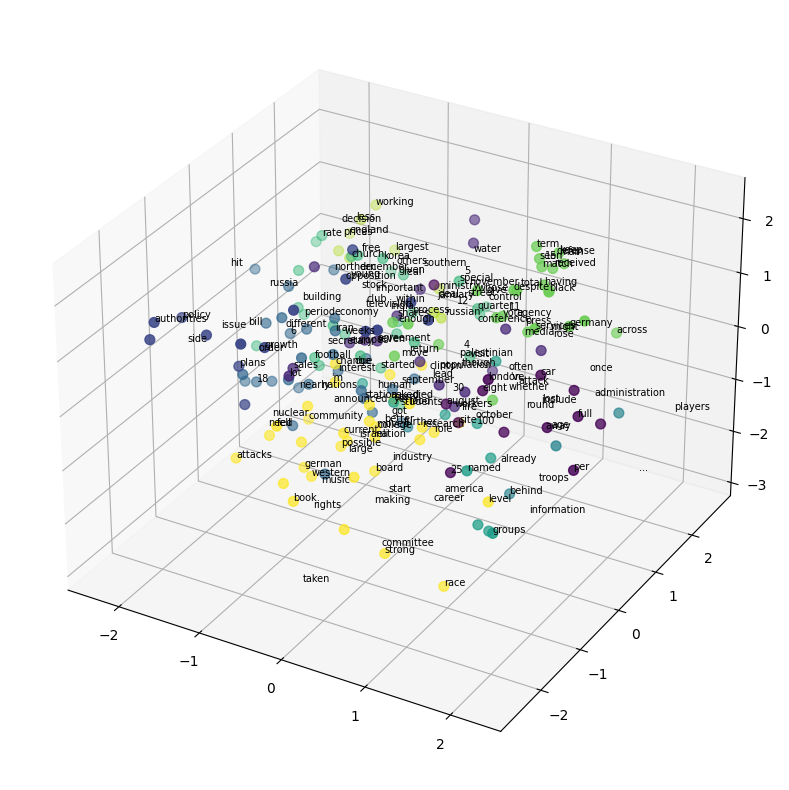

In [ ]:
fig = plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vectors_3d[100:280, 0], vectors_3d[100:280, 1], vectors_3d[100:280, 2], c=labels[100:280], s=50)

for i, word in enumerate(glove_words[100:280]):
  ax.text(vectors_3d[i, 0], vectors_3d[i, 1], vectors_3d[i, 2], word, fontsize=7)

plt.show()

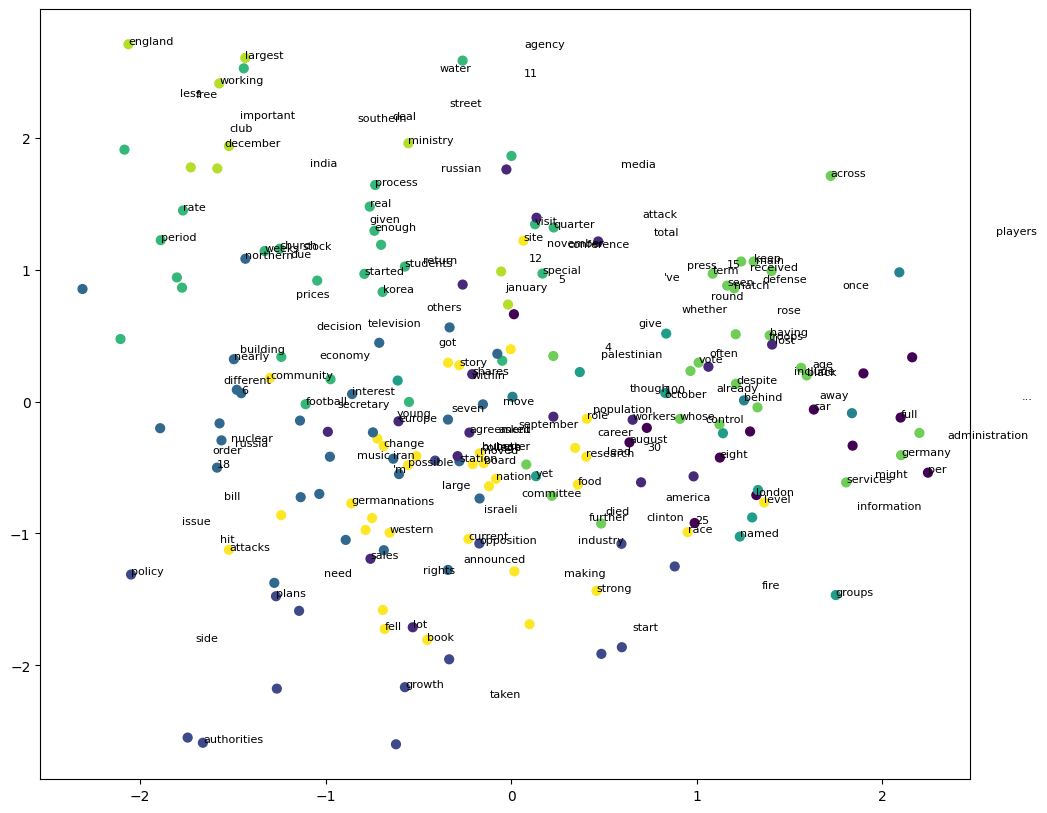

In [ ]:
fig = plt.figure(figsize=(12,10), dpi=100)
ax = fig.add_subplot(111)
ax.scatter(vectors_2d[100:280, 0], vectors_2d[100:280, 1], c=labels[100:280], s=40)

for i, word in enumerate(glove_words[100:280]):
  ax.text(vectors_2d[i, 0], vectors_2d[i, 1], word, fontsize=8)

plt.show()

In [ ]:
queen = word2vec['queen']
king = word2vec['king']
print(cosine_similarity(queen.reshape(1, -1)-king.reshape(1, -1)))

man = word2vec['man']
woman = word2vec['woman']
print(cosine_similarity(woman.reshape(1, -1)-man.reshape(1, -1)))

[[0.99999994]]
[[1.0000001]]


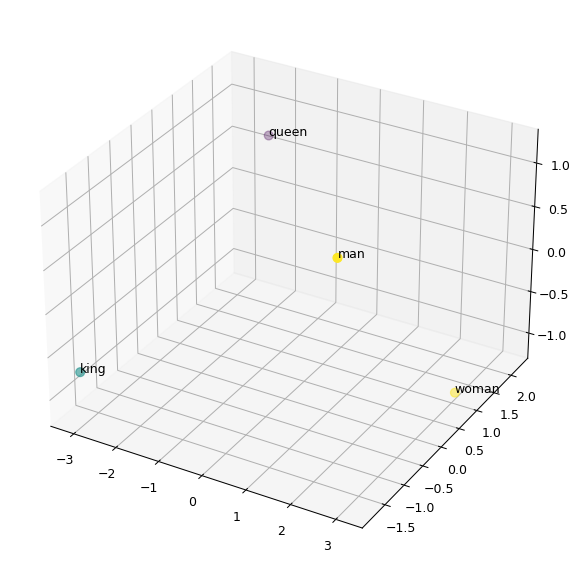

In [ ]:
words = ["man", "king", "woman", "queen"]
vectors = [glove_dict[i] for i in words]
new_labels = [labels[i] for i in range(len(glove_words)) if glove_words[i] in words]

pca = PCA(n_components=3)
vectors_3d = pca.fit_transform(vectors)

fig = plt.figure(figsize=(10,8), dpi=90)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vectors_3d[:, 0], vectors_3d[:, 1], vectors_3d[:, 2], s=50, c=new_labels)

for i, word in enumerate(words):
  ax.text(vectors_3d[i, 0], vectors_3d[i, 1],vectors_3d[i,2], word, fontsize=10)

plt.show()

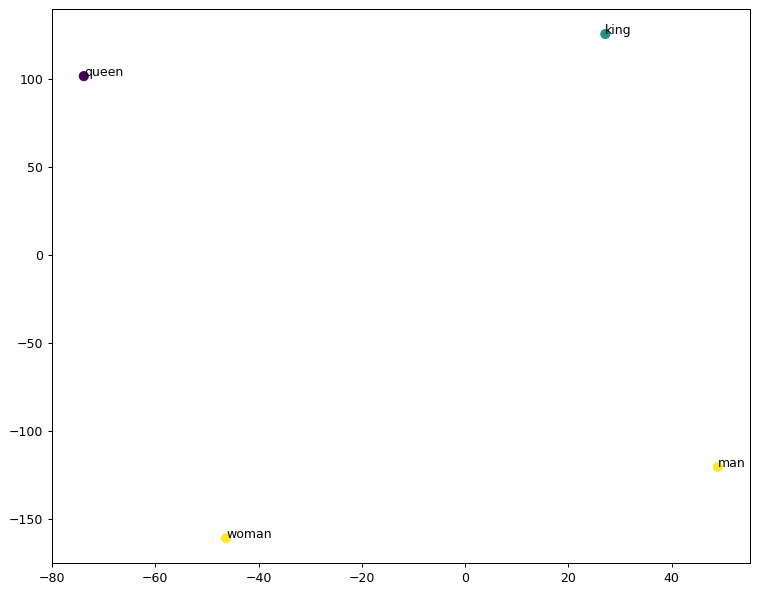

In [ ]:
words = ["man", "king", "woman", "queen"]
vectors = np.array([glove_dict[i] for i in words])
new_labels = [labels[i] for i in range(len(glove_words)) if glove_words[i] in words]

tsne = TSNE(n_components=2, perplexity=2)
vectors_2d = tsne.fit_transform(vectors)

fig = plt.figure(figsize=(10,8), dpi=90)
ax = fig.add_subplot(111)
ax.scatter(vectors_2d[:, 0], vectors_2d[:, 1], s=50, c=new_labels)

for i, word in enumerate(words):
  ax.text(vectors_2d[i, 0], vectors_2d[i, 1], word, fontsize=10)
plt.show()

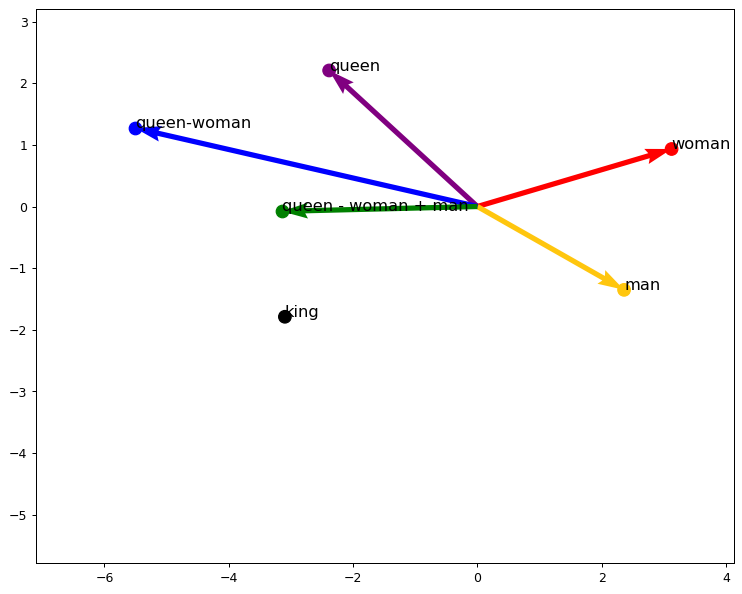

In [ ]:
words = ["man", "king", "woman", "queen"]
vectors = np.array([glove_dict[i] for i in words])
new_labels = ['#ffc60e', 'black', 'red', 'purple']

pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

fig = plt.figure(figsize=(10, 8), dpi=90)
ax = fig.add_subplot(111)
ax.scatter(vectors_2d[:, 0], vectors_2d[:, 1], s=100, c=new_labels)

for i, word in enumerate(words):
    ax.text(vectors_2d[i, 0], vectors_2d[i, 1], word, fontsize=13)

points = {word: vectors_2d[i] for i, word in enumerate(words)}
queen_point = points['queen']
woman_point = points['woman']
man_point = points['man']

queen_woman = queen_point - woman_point
plus_man = queen_woman + man_point

ax.quiver(0, 0, queen_point[0], queen_point[1], angles='xy', scale_units='xy', scale=1, color='purple',linestyle='dotted')
ax.quiver(0, 0, woman_point[0], woman_point[1], angles='xy', scale_units='xy', scale=1, color='red',linestyle='dotted')
ax.quiver(0, 0, man_point[0], man_point[1], angles='xy', scale_units='xy', scale=1, color='#ffc60e',linestyle='dotted')

ax.quiver(0, 0, queen_woman[0], queen_woman[1], angles='xy', scale_units='xy', scale=1, color='blue',linestyle='dotted')
ax.quiver(0, 0, plus_man[0], plus_man[1], angles='xy', scale_units='xy', scale=1, color='green',linestyle='dotted')

ax.scatter(plus_man[0], plus_man[1], s=100, c='green')
ax.text(plus_man[0], plus_man[1], 'queen - woman + man', fontsize=13)

ax.scatter(queen_woman[0], queen_woman[1], s=100, c='blue')
ax.text(queen_woman[0], queen_woman[1], 'queen-woman', fontsize=13)

ax.set_xlim(min(vectors_2d[:, 0]) - 4, max(vectors_2d[:, 0]) + 1)
ax.set_ylim(min(vectors_2d[:, 1]) - 4, max(vectors_2d[:, 1]) + 1)
plt.show()

In [ ]:
#fasttext
model = FastText(sentences = text,
                          size  = 256,
                          min_count=2, window=5, workers=4)

In [ ]:
model.wv.most_similar('film')

[('filmi', 0.9351862072944641),
 ('ilm', 0.9261810779571533),
 ('filmdom', 0.8971229791641235),
 ('filmgo', 0.8970991373062134),
 ('filmak', 0.8844096064567566),
 ('filmgoer', 0.86628258228302),
 ('unfilm', 0.8655861616134644),
 ('filmabl', 0.8643466830253601),
 ('filmirag', 0.8637959361076355),
 ('filmic', 0.8573119044303894)]

In [ ]:
model.wv.most_similar('king')

[('cking', 0.938302755355835),
 ('kingpin', 0.8656144142150879),
 ('kingdom', 0.8173710107803345),
 ('bing', 0.8026952743530273),
 ('jing', 0.7833297252655029),
 ('ping', 0.7629743218421936),
 ('ying', 0.7610477209091187),
 ('zing', 0.7439430952072144),
 ('ting', 0.7436357736587524),
 ('mazing', 0.7312380075454712)]

In [ ]:
model.wv.doesnt_match(['cat','dog', 'bird'])

'bird'

In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(model.wv.vectors)
labels = kmeans.labels_

In [ ]:
words = model.wv.index2word

pca = PCA(n_components=3)
vectors_3d = pca.fit_transform(model.wv.vectors)

print(pca.explained_variance_ratio_*100)

[16.99187   8.518136  6.476625]


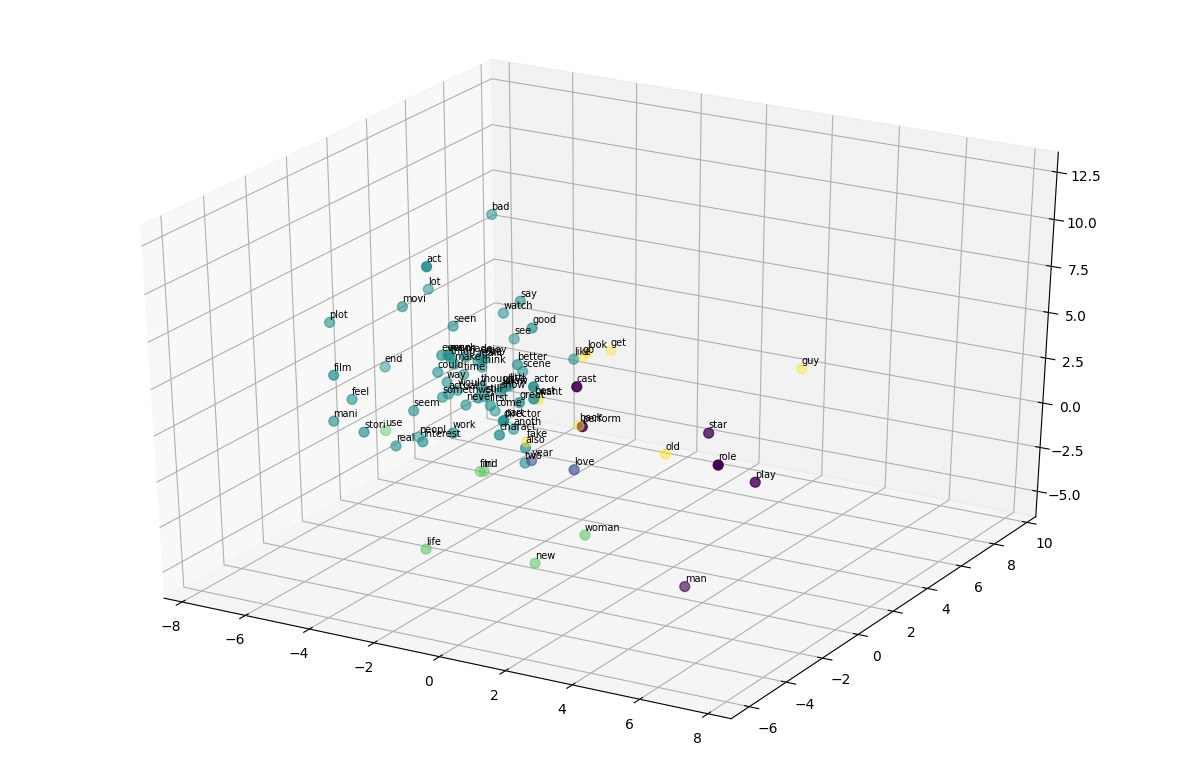

In [ ]:
fig = plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vectors_3d[0:80, 0], vectors_3d[0:80, 1], vectors_3d[0:80, 2], c=labels[0:80], s=50)

for i, word in enumerate(words[0:80]):
  ax.text(vectors_3d[i, 0], vectors_3d[i, 1], vectors_3d[i, 2]+0.25, word, fontsize=7)

plt.show()

## Choose final Embedding & Prediction

In [ ]:
text = []
for i in all_data:
  text.append(i)

bigrams = Phrases(sentences=text)
trigrams = Phrases(sentences=bigrams[text])
embedding_model = Word2Vec(sentences=trigrams[bigrams[text]],
                          vector_size=256,
                          min_count=2, window=5, workers=4)
embedding_matrix = embedding_model.wv.vectors

In [ ]:
print(bigrams['space station near the solar system'.split()])

['space_station', 'near', 'the', 'solar_system']


In [ ]:
embedding_model.wv.doesnt_match(['starship','cat','planet','dog'])

'starship'

In [ ]:
vobac_size = len(embedding_model.wv.key_to_index)

In [ ]:
X_train = all_data[:train_data.shape[0]]
X_train_gram = trigrams[bigrams[X_train]]

word_index_vocab = embedding_model.wv.key_to_index
tokenizer = Tokenizer(num_words = vobac_size)
tokenizer.word_index = word_index_vocab

X_train_sequences = tokenizer.texts_to_sequences(X_train_gram)
X_train_padded = pad_sequences(X_train_sequences, maxlen=150, padding='post')

In [ ]:
model = Sequential()
model.add(layers.Embedding(input_dim=embedding_matrix.shape[0],
                                   output_dim=embedding_matrix.shape[1],
                                   input_length=150,
                                   weights=[embedding_matrix],
                                   trainable=False))
model.add(layers.Bidirectional(layers.LSTM(128, recurrent_dropout=0.1)))
model.add(layers.Dense(128))
model.add(layers.Reshape((1,128)))
model.add(layers.Bidirectional(layers.LSTM(256, recurrent_dropout=0.1)))
model.add(layers.Dense(64))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 150, 256)          41822464  
                                                                 
 bidirectional_11 (Bidirect  (None, 256)               394240    
 ional)                                                          
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 reshape (Reshape)           (None, 1, 128)            0         
                                                                 
 bidirectional_12 (Bidirect  (None, 512)               788480    
 ional)                                                          
                                                                 
 dense_13 (Dense)            (None, 64)               

In [ ]:
model.compile(loss="binary_crossentropy",  optimizer='adam',  metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_padded, train_data['sentiment'], batch_size=100, epochs=10, validation_split=0.2)

Epoch 1/10
600/600 [==============================] - 276s 446ms/step - loss: 0.3313 - accuracy: 0.8612 - val_loss: 0.2579 - val_accuracy: 0.8971
Epoch 2/10
600/600 [==============================] - 265s 441ms/step - loss: 0.2365 - accuracy: 0.9064 - val_loss: 0.2351 - val_accuracy: 0.9068
Epoch 3/10
194/600 [========>.....................] - ETA: 2:42 - loss: 0.1789 - accuracy: 0.9315

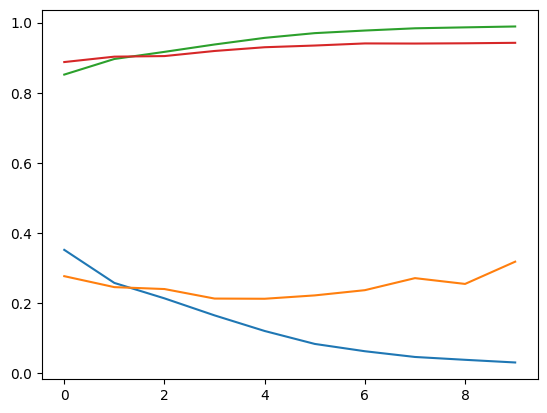

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

## Submission

In [ ]:
X_test = all_data[-test_data.shape[0]:]
X_test_gram = trigrams[bigrams[X_test]]

X_test_sequences = tokenizer.texts_to_sequences(X_test_gram)

X_test_padded = pad_sequences(X_test_sequences, maxlen=150, padding='post')

In [ ]:
y_pred = model.predict(X_test_padded)
y_pred = [1 if i>0.5 else 0 for i in y_pred]
test_data['sentiment'] = y_pred
test_data.to_csv('submission.csv', index=False, columns=['id','sentiment'])

782/782 [==============================] - 69s 85ms/step


In [ ]:
# https://www.kaggle.com/code/alexcherniuk/imdb-review-word2vec-bilstm-99-acc/notebook